<a href="https://colab.research.google.com/github/Aditya-11/Reinforcement_Learning_based_Algorithmic_Trading-Al/blob/master/stock123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# environment 

import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
import itertools

# Intelligent Stock Trading Agent
# Agent : Deep Q network 


"""
3 stock trading env 

(State_Space) ->  # of stock owned, current stock prices, cash in hand

- array of length n_stock*2 + 1
- price is discretized (to integer) to reduce state space
- use close price for each stock
- cash in hand is evaluated at each step based on action performed


(Action_Space) -> sell (0)
               -> hold (1)
               -> and buy (2)

when selling, sell all the shares
when buying, buy as many as cash in hand allows
if buying multiple stock, equally distribute cash in hand and then utilize the balance
"""

class Trade_env(gym.Env):
  def __init__(self,train_data, init_invest):
    # data
    #self.stock_price_history = np.around(train_data)
    self.stock_price_history = train_data
    #self.n_stock, self.n_step = self.stock_price_history.shape
    #print(self.stock_price_history.shape)
    self.n_stock = self.stock_price_history.shape[0]
    self.n_step = self.stock_price_history[0].shape
    print("n_step",self.n_step)
    #print(self.n_step)
    # instance attributes
    self.init_invest = init_invest
    self.cur_step = None
    self.stock_owned = None
    self.stock_price = None
    self.cash_in_hand = None

    # action space
    self.action_space = spaces.Discrete(3**self.n_stock)


    # observation space: give estimates in order to sample and build scaler
    sm1 = self.stock_price_history[0][:].max()
    sm2 = self.stock_price_history[1][:].max()
    sm3 = self.stock_price_history[2][:].max()

    stock_max_price = [sm1,sm2,sm3]

    #print(stock_max_price)
    
    stock_range = [[0, init_invest * 2 // mx] for mx in stock_max_price]
    price_range = [[0, mx] for mx in stock_max_price]
    cash_in_hand_range = [[0, init_invest * 2]]
    
    #self.observation_space = stock_range + price_range + cash_in_hand_range
    stock_range = [[int(i) for i in stock_range[0]]]
    price_range = [[int(i) for i in price_range[0]]]
    cash_in_hand_range = [[int(i) for i in cash_in_hand_range[0]]]
    #print(stock_range + price_range + cash_in_hand_range)
    #self.observation_space = spaces.MultiDiscrete([(0, 17), (0, 117), (0, 2000)])
    self.observation_space = spaces.MultiDiscrete([18,118,2001])

    #print(self.observation_space)
    #self.observation_space = spaces.MultiDiscrete(stock_range+ price_range + cash_in_hand_range)

    # seed and start
    self._seed()
    self._reset()

  def _seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]

  def _reset(self):
    self.cur_step = 0
    self.stock_owned = [0] * self.n_stock
    #self.stock_price = self.stock_price_history[:, self.cur_step]
    self.stock_price = [self.stock_price_history[i][self.cur_step] for i in range(3)]
    #print("stock_price",self.stock_price)
    self.cash_in_hand = self.init_invest
    return self._get_obs()

  def _step(self, action):
    assert self.action_space.contains(action)
    prev_val = self._get_val()
    #print("step no: ",self.cur_step)
    self.cur_step += 1
    #self.stock_price = self.stock_price_history[:][self.cur_step] # update price
    self.stock_price = [self.stock_price_history[i][self.cur_step-1] for i in range(3)]
    #print(self.stock_price)
    
    self._trade(action)
    cur_val = self._get_val()
    reward = cur_val - prev_val
    if (self.cur_step == self.n_step[0]-2):
      done = True
    else :
      done = False
    info = {'cur_val': cur_val}
    return self._get_obs(), reward, done, info

  def _get_obs(self):
    obs = []
    obs.extend(self.stock_owned)
    obs.extend(list(self.stock_price))
    obs.append(self.cash_in_hand)
    #print(obs)
    return obs

  def  _get_val(self):
    return np.sum(np.array(self.stock_owned) * np.array(self.stock_price)) + self.cash_in_hand

  def _trade(self, action):
    # all combo to sell(0), hold(1), or buy(2) stocks
    action_combo = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))
    action_vec = action_combo[action]

    # one pass to get sell/buy index
    sell_index = []
    buy_index = []
    for i, a in enumerate(action_vec):
      if a == 0:
        sell_index.append(i)
      elif a == 2:
        buy_index.append(i)
    
        # two passes: sell first, then buy; might be naive in real-world settings
    if sell_index:
      for i in sell_index:
        self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
        self.stock_owned[i] = 0

    if buy_index:
      can_buy = True
      while can_buy:
        for i in buy_index:
          if self.cash_in_hand > self.stock_price[i]:
            self.stock_owned[i] += 1 # buy one share
            self.cash_in_hand -= self.stock_price[i]
          else:
            can_buy = False

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


def get_data(col='close'):
  """ Returns a 3 x n_step array """
  msft = pd.read_csv('daily_MSFT.csv', usecols=[col])
  ibm = pd.read_csv('daily_IBM.csv', usecols=[col])
  qcom = pd.read_csv('daily_QCOM.csv', usecols=[col])


  msft = msft.iloc[1:1400]
  ibm = msft.iloc[1:1400]
  qcom = qcom.iloc[1:1400]
  # recent price are at top; reverse it
  return np.array([msft[col].values[::-1],
                   ibm[col].values[::-1],
                   qcom[col].values[::-1]])


def get_scaler(env):
  """ Takes a env and returns a scaler for its observation space """
  low = [0] * (env.n_stock * 2 + 1)

  high = []
  #max_price = env.stock_price_history.max(axis=1)
  max_price = [env.stock_price_history[i][:].max() for i in range(3)]
  #min_price = env.stock_price_history.min(axis=1)
  min_price = [env.stock_price_history[i][:].min() for i in range(3)]

  #print(max_price)
  max_cash = env.init_invest * 3 # 3 is a magic number...
  #print("max_cash",max_cash)
  
  #max_stock_owned = max_cash // min_price

  max_stock_owned = [max_cash//min_price[i] for i in range(3)]

  for i in max_stock_owned:
    high.append(i)
  for i in max_price:
    high.append(i)
  high.append(max_cash)

  scaler = StandardScaler()
  scaler.fit([low, high])
  return scaler


In [ ]:
import tensorflow.keras.backend as K


def huber_loss(y_true, y_pred, clip_delta=1.0):
    """Huber loss - Custom Loss Function for Q Learning
    Links: 	https://en.wikipedia.org/wiki/Huber_loss
            https://jaromiru.com/2017/05/27/on-using-huber-loss-in-deep-q-learning/
    """
    error = y_true - y_pred
    cond = K.abs(error) <= clip_delta
    squared_loss = 0.5 * K.square(error)
    quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)
    return K.mean(tf.where(cond, squared_loss, quadratic_loss))


In [ ]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model

import numpy as np
import random 
from collections import deque

class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size
        self.action_size = 27
        self.memory = deque(maxlen = 1000000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval

        self.gamma = 0.971
        self.epsilon = 1.0
        self.epsilon_min = 0.000001
        self.epsilon_decay = 0.9995
        self.loss = huber_loss

        self.model = load_model(model_name) if is_eval else self._model()

    def _model(self):
        model = Sequential()
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(Dense(units=64,  activation="relu"))
        model.add(BatchNormalization())
        model.add(Dense(units=8, activation="relu"))
        model.add(BatchNormalization())
        model.add(Dense(self.action_size))
        model.compile(loss = self.loss, optimizer = Adam(lr=0.00587))   
        return model 

    def act(self,state):
        if not self.is_eval and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        #print(state)
        options = self.model.predict(state)
        return np.argmax(options[0])

    def test_act(self,state):
        options = self.model.predict(state)
        return np.argmax(options[0])

    def remember(self,state,action,reward,next_state,done):
        self.memory.append((state,action,reward,next_state,done))

    def experience_replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        
        """
        for i in range(l - batch_size + 1,1):
            mini_batch.append(self.memory[i])
        """

        mini_batch = random.sample(self.memory,batch_size)

        for state , action , reward , next_state , done in mini_batch:
            target = reward

            if not done:
                #print(next_state)
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

            target_f = self.model.predict(state)
            target_f[0][action] = target

            self.model.fit(state, target_f , epochs = 1, verbose = 0)

        if self.epsilon > self.epsilon_min :
            self.epsilon *= self.epsilon * self.epsilon_decay


In [ ]:
# Train the agent

# heavy_trader

import pickle
import time
import numpy as np
import argparse
import re

no_episode = 9

batch_size = 20

timestamp = time.strftime('%Y%m%d%H%M')

#data = np.around(get_data())

data = get_data()

#data = data[:][:3000]

#train_data = data[:, :3526]

train_data = data

#test_data = data[:, 3526:]

print(train_data[0].shape)

# define the environment
#env = TradingEnv(train_data, 1000)

env = Trade_env(train_data,1000)
#state_size = env.observation_space.shape
state_size = 7
action_size = env.action_space.n


# define the agent

print("state -> ",state_size)
print("action -> ",action_size)

#agent = Stock_Agent(state_size,action_size,batch_size)

agent = Agent(state_size)

scaler = get_scaler(env)
portfolio_value = []

with tf.device('/gpu:0'):
  for e in range(no_episode):
    actions_taken = []
    print("Episode no -> ", e)
    state = env._reset()
    state = scaler.transform([state])[0]
    state = np.array([state])
    #print(state)
    #print(state.shape)

    for time in range(env.n_step[0]):
      print(time,end = " ")  
      action = agent.act(state)
      actions_taken.append(action)
      next_state, reward, done, info = env._step(action)
      next_state = scaler.transform([next_state])[0]
      next_state = np.array([next_state])
      agent.remember(state, action, reward, next_state,done)
      state = next_state
      if done or env.cur_step == 4523:
        print("episode: {}/{}, episode end value: {}".format(e + 1, no_episode, info['cur_val']))
        portfolio_value.append(info['cur_val']) # append episode end portfolio value
        print(actions_taken)
        break
      if len(agent.memory) > batch_size:
        agent.experience_replay(batch_size)

(1399,)
n_step (1399,)
state ->  7
action ->  27
Episode no ->  0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 

In [ ]:
print(portfolio_value)

In [ ]:


Test_no = 1

col = 'close'

msft = pd.read_csv('daily_MSFT.csv', usecols=[col])
ibm = pd.read_csv('daily_IBM.csv', usecols=[col])
qcom = pd.read_csv('daily_QCOM.csv', usecols=[col])

msft = msft.iloc[2000:2500]
ibm = ibm.iloc[2000:2500]
qcom = qcom.iloc[2000:2500]

# recent price are at top; reverse it
test_data = np.array([msft[col].values[::-1],
                   ibm[col].values[::-1],
                   qcom[col].values[::-1]])
#print(test_data[1])

env = Trade_env(test_data,1000)

state_size = 7
action_size = env.action_space.n
batch_size = 30

# load the weights of the model
agent = Stock_Agent(state_size,action_size,batch_size)
#print(agent.stock_price_history.shape)
agent.model_load_weight()
scaler = get_scaler(env)


print(agent.model.summary())

for e in range(Test_no):
  print("Test_no no ->  ",e)
  state = env._reset()
  state = scaler.transform([state])[0]
  portfolio_val = []
  action_val = []
  for time in range(env.n_step[0]):
    action = agent.test_act(state)
    action_val.append(action)
    next_state, reward, done, info = env._step(action)
    portfolio_val.append(info['cur_val'])
    next_state = scaler.transform([next_state])[0]
    state = next_state


In [ ]:
print(porfolio_val)

In [ ]:
# save the weight 

agent.model.save('heavy_trader.h5')
from google.colab import files
files.download('heavy_trader.h5')

In [ ]:
agent.model.save('heavy_trader.h5')
from google.colab import files
files.download('heavy_trader.h5')

In [ ]:
# heavy trader_new 


import pickle
import time
import numpy as np
import argparse
import re

no_episode = 10
batch_size = 20
timestamp = time.strftime('%Y%m%d%H%M')

#data = np.around(get_data())
data = get_data()
#data = data[:][:3000]

#train_data = data[:, :3526]
train_data = data
#test_data = data[:, 3526:]

print(train_data[0].shape)

# define the environment
#env = TradingEnv(train_data, 1000)
env = Trade_env(train_data,1000)
#state_size = env.observation_space.shape
state_size = 7
action_size = env.action_space.n


# define the agent

print("state -> ",state_size)
print("action -> ",action_size)

#agent = Stock_Agent(state_size,action_size,batch_size)

#agent = Agent(state_size)

model_name = 'heavy_trader.h5'

window_size = state_size

agent = Agent(window_size , True , model_name)

scaler = get_scaler(env)

portfolio_value = []

with tf.device('/gpu:0'):
  for e in range(no_episode):
    actions_taken = []
    print("Episode no -> ", e+9)
    state = env._reset()
    state = scaler.transform([state])[0]
    state = np.array([state])
    #print(state)
    #print(state.shape)
    for time in range(env.n_step[0]):
      print(time,end = " ")  
      action = agent.act(state)
      actions_taken.append(action)
      next_state, reward, done, info = env._step(action)
      next_state = scaler.transform([next_state])[0]
      next_state = np.array([next_state])
      agent.remember(state, action, reward, next_state,done)
      state = next_state
      if done or env.cur_step == 4523:
        print("episode: {}/{}, episode end value: {}".format(e +9, no_episode+9, info['cur_val']))
        portfolio_value.append(info['cur_val']) # append episode end portfolio value
        print(actions_taken)
        break
      if len(agent.memory) > batch_size:
        agent.experience_replay(batch_size)

(1399,)
n_step (1399,)
state ->  7
action ->  27
Episode no ->  9
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 

In [ ]:
print(portfolio_value)

In [ ]:
# save dqtrader_model_11
agent.model.save('heavy_trader_new.h5')
from google.colab import files
files.download('heavy_trader_new.h5')

In [ ]:
Test_no = 1

col = 'close'

msft = pd.read_csv('daily_MSFT.csv', usecols=[col])
ibm = pd.read_csv('daily_IBM.csv', usecols=[col])
qcom = pd.read_csv('daily_QCOM.csv', usecols=[col])

msft = msft.iloc[3500:4000]
ibm = ibm.iloc[3500:4000]
qcom = qcom.iloc[3500:4000]

# recent price are at top; reverse it
test_data = np.array([msft[col].values[::-1],
                   ibm[col].values[::-1],
                   qcom[col].values[::-1]])
#print(test_data[1])

env = Trade_env(test_data,1000)

state_size = 7
action_size = env.action_space.n
batch_size = 30

# load the weights of the model
agent = Agent(state_size,True,'heavy_trader.h5')
#print(agent.stock_price_history.shape)
scaler = get_scaler(env)

print(agent.model.summary())

for e in range(Test_no):
  print("Test_no no ->  ",e)
  state = env._reset()
  state = scaler.transform([state])[0]
  state = np.array([state])
  portfolio_val = []
  action_val = []
  for time in range(env.n_step[0]):
    action = agent.test_act(state)
    action_val.append(action)
    next_state, reward, done, info = env._step(action)
    portfolio_val.append(info['cur_val'])
    next_state = scaler.transform([next_state])[0]
    next_state = np.array([next_state])
    state = next_state


n_step (500,)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
batch_normalization_5 (Batch (None, 8)  

Text(0, 0.5, 'value')

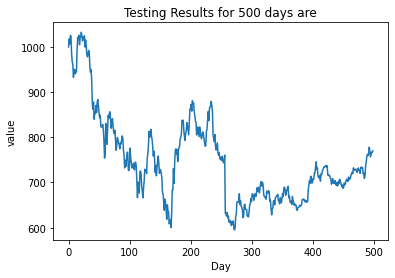

In [ ]:
import matplotlib.pyplot as plt
x = portfolio_val
plt.plot(range(500),x)
plt.title("Testing Results for 500 days are")
plt.xlabel("Day")
plt.ylabel("value")

In [ ]:
print(portfolio_val)

[1000.0, 1017.22, 1006.4200000000001, 1025.5, 1023.5800000000002, 984.8800000000001, 967.54, 961.4200000000001, 932.74, 944.8000000000002, 950.44, 940.3600000000001, 943.4800000000001, 944.9200000000001, 992.5, 1021.3600000000001, 1018.6600000000001, 1025.74, 1004.74, 1020.4000000000001, 1023.6400000000001, 1032.4, 1021.8400000000001, 1013.0799999999999, 1021.8400000000001, 1017.1, 1024.48, 999.7600000000001, 1015.0000000000001, 1002.46, 982.9000000000001, 978.0400000000002, 983.1400000000001, 992.0200000000001, 985.6000000000001, 955.5400000000002, 943.9000000000001, 949.9000000000001, 924.8800000000001, 873.94, 861.8199999999999, 878.0200000000001, 840.0400000000001, 855.3399999999999, 852.4, 870.2200000000001, 854.8000000000002, 878.0800000000002, 883.3600000000001, 867.2800000000002, 854.0800000000002, 843.2800000000001, 848.8000000000001, 823.4200000000001, 822.94, 822.2800000000002, 828.46, 816.58, 794.2, 753.8800000000001, 761.98, 830.6800000000001, 798.46, 784.5400000000001, 81